In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fbprophet
import logging

logging.getLogger().setLevel(logging.ERROR)
    
%matplotlib inline

plt.style.use('bmh')

%store -r WORKDIR
if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/BZ241WX/Documents/InfNet/CursoPosDataScience/mit_data_science/'

test_samples = 52
min_samples = test_samples
n_stores = 3
n_dept = 3


data_proc_file = WORKDIR + '/Data/Processed/retail.parquet'
save_file = WORKDIR + '/Data/Modeling/forecast_results.parquet'

time_col = 'Date'
grain_col = ['Store', 'Dept']
target_col = 'Weekly_Sales'

variable_names = ['IsHoliday', 'Type', 'Size','Temperature',
                  'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                  'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

pd.plotting.register_matplotlib_converters()

# Carga dos Dados 

In [76]:
df = pd.read_parquet(data_proc_file)

store_list = df.Store.unique().tolist()[:n_stores]
dept_list = df.Dept.unique().tolist()[:n_dept]

df = df[df.Store.isin(store_list)].copy()
df = df[df.Dept.isin(dept_list)].copy()


print('shape:', df.shape)
print('columns:', df.columns)

shape: (1287, 16)
columns: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')


# Descricao dos Dados 

In [85]:
df.describe()

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,25068.117280,0.069930,130338.000000,69.319114,3.219699,2594.099487,901.844149,435.430420,1113.925711,1526.848904,217.011578,7.470417
std,20312.820974,0.255128,68967.668537,14.212531,0.425981,5898.481182,5705.281720,4939.380697,3723.590692,3391.033271,4.678144,0.532558
min,2444.090000,0.000000,37392.000000,33.020000,2.514000,0.000000,0.000000,0.000000,0.000000,0.000000,209.998458,6.034000
25%,10078.630000,0.000000,37392.000000,58.760000,2.759000,0.000000,0.000000,0.000000,0.000000,0.000000,212.903312,7.143000
50%,16976.190000,0.000000,151315.000000,70.310000,3.290000,0.000000,0.000000,0.000000,0.000000,0.000000,215.694438,7.564000
75%,42233.695000,0.000000,202307.000000,81.840000,3.594000,3221.250000,10.470000,3.830000,570.570000,1743.540000,221.309517,7.866000
max,93511.030000,1.000000,202307.000000,93.340000,3.907000,75149.790000,92523.940000,77451.260000,48159.860000,36430.330000,226.987364,8.324000


In [77]:


def split_last_n_by_grain(df, ntest, time_column_name, grain_column_names):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-ntest])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-ntest:])
    return df_head, df_tail



df_train, df_test = split_last_n_by_grain(df, test_samples, time_col, grain_col)

print('Train:', df_train.shape)
print('Test :', df_test.shape)

Train: (819, 16)
Test : (468, 16)


# Construção do Pipeline 

In [78]:
def mape(y_true, y_pred):
    return (np.abs(y_pred - y_true)/y_true).mean() * 100
    
df_model_result=pd.DataFrame()
result_list = []
for store in store_list:
    print('Store ', store, end='')
    idx_store = df.Store == store
    for dept in dept_list:
        print('Dept ', dept, end='')
        idx_dept = df_train.Dept == dept
        # Get data
        Xtrn = df_train.loc[(df_train.Store == store) & (df_train.Dept == dept), [time_col, target_col]].copy()
        Xtst = df_test.loc[(df_test.Store == store) & (df_test.Dept == dept), [time_col, target_col]].copy()    
        Xrefit = df.loc[(df.Store == store) & (df.Dept == dept), [time_col, target_col]].copy()

        Xtrn.columns = ['ds', 'y']
        if Xtrn.shape[0] < min_samples:
            print('=> less than', min_samples, '. Ignored.(', Xtrn.shape[0],')')
            continue

        # Train Model
        model = fbprophet.Prophet().fit(Xtrn)
        # Evaluate Model
        n_periods = Xtst.shape[0]
        forecast_data = model.make_future_dataframe(
            periods=n_periods,
            include_history=True
            )
        df_forecast = model.predict(forecast_data).set_index('ds')
        forecast     = df_forecast.yhat.rename('forecast').to_frame()
        
        # Score model
        score = mape(Xtst.set_index(time_col).values, forecast[-n_periods:].values)
        print(' mape %.2f %%'%score)

        # Refit model
        Xrefit.columns = ['ds','y']
        model = fbprophet.Prophet().fit(Xrefit)
        # Forecast Model
        n_periods = Xtst.shape[0]
        forecast_data = model.make_future_dataframe(
            periods=n_periods,
            include_history=True
            )
        df_forecast = model.predict(forecast_data).set_index('ds')
        forecast     = df_forecast.yhat.rename('forecast').to_frame()
        forecast_low  =  df_forecast.yhat_lower.rename('forecast_lo').to_frame()
        forecast_up   =  df_forecast.yhat_upper.rename('forecast_up').to_frame()
        
        forecast_result = pd.concat((forecast, forecast_low, forecast_up), axis=1)
        result = pd.concat((Xrefit.set_index('ds'), forecast_result), axis=1)
        result.rename({'y':target_col}, axis=1, inplace=True)
        result.rename_axis(time_col, inplace=True)
        result['Store'] = store
        result['Dept'] = dept
        result_list.append(result)
        
        
df_results = pd.concat(result_list)

Store  1Dept  1 mape 19.44 %
Dept  2 mape 5.37 %
Dept  3 mape 47.38 %
Store  2Dept  1 mape 17.84 %
Dept  2 mape 6.33 %
Dept  3 mape 58.06 %
Store  3Dept  1 mape 18.70 %
Dept  2 mape 9.06 %
Dept  3 mape 30.58 %


# Exportar Resultados 

In [99]:
df_results.head()

,Weekly_Sales,forecast,forecast_lo,forecast_up,Store,Dept
Date,,,,,,
2010-02-05,24924.50,31703.400126,24137.001228,39254.998032,1,1
2010-02-12,46039.49,37709.465678,30122.519673,45275.961488,1,1
2010-02-19,41595.55,36412.196439,29019.039751,43181.751960,1,1
2010-02-26,19403.54,28518.666365,20966.761747,36148.293556,1,1
2010-03-05,21827.90,19514.149121,12147.538901,26441.680775,1,1


In [106]:
final_results = (df_results.drop(target_col, axis=1)
                           .reset_index()
                           .merge(df, how='left', on=grain_col + [time_col])
)
final_results.to_parquet(save_file)
final_results.to_excel(save_file.replace(".parquet",".xlsx"))

# Plot Forecast 

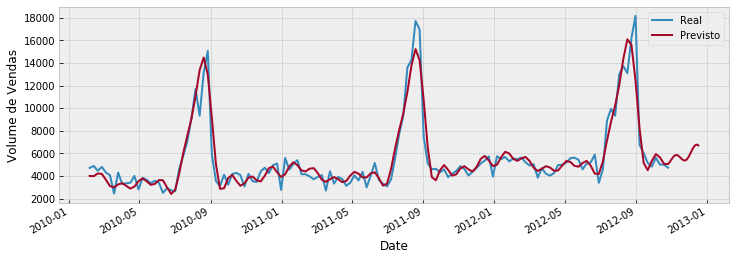

In [91]:
plt.figure(figsize=(12,4))
result.Weekly_Sales.plot(label='Real')
result.forecast.plot(label='Previsto')
plt.ylabel('Volume de Vendas')
plt.legend()

[{'label': '1', 'value': '1'},
 {'label': '2', 'value': '2'},
 {'label': '3', 'value': '3'}]